<a href="https://colab.research.google.com/github/gravityrahul/DeepLearning/blob/master/Copy_of_KDD_2020_nPlan_calibration_session.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to calibrate your neural network classifer:
## Getting accurate probabilities from your neural network model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nplan-io/kdd2020-calibration/blob/master/tutorial/KDD%202020%20-%20nPlan%20calibration%20session.ipynb)

## 1. Introduction

In this tutorial we'll use the CIFAR-10 image dataset, and a classifier trained on it, to explore what model confidence calibration is, how we can measure it, and what methods we can put in place to rectify poorly calibrated models.

In [ ]:
# import relevant modules
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import cifar10
import tensorflow.keras.utils
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# we must split our data further, as calibration procedures require a holdout set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, shuffle=False)

#### CIFAR-10
CIFAR-10 is a dataset containing a collection of images falling into 10 classes: airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. It contains 60 000 low resolution (32x32) images and is often used to train ML and computer vision models. This is commonly divided into 50 000 training images and 10 000 testing images. The low resolution allows for quick testing of different models.

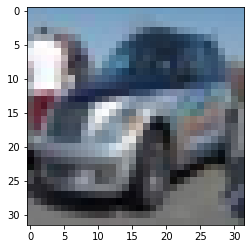

In [ ]:
plt.imshow(x_train[112,])
plt.show()

First we need to do some preprocessing of the data. This will allow our model to achieve higher accuracy.

In [ ]:
# Normalize data.
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean from each image
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_val -= x_train_mean
x_test -= x_train_mean

# translate data to categorical
y_train_labels = y_train
y_val_labels = y_val
y_test_labels = y_test

y_train = tensorflow.keras.utils.to_categorical(y_train, 10)
y_val = tensorflow.keras.utils.to_categorical(y_val, 10)
y_test = tensorflow.keras.utils.to_categorical(y_test, 10)

#### The models
The obvious next step would be training a model but as we have limited time and resources, we will be using two pre-trained models:
- [Keras ResNet model](https://github.com/keras-team/keras/blob/master/examples/cifar10_resnet.py)
- [A binary simplification of this model - that tries to discriminate between dogs and cats!](fill_me)

In [ ]:
# model = Model(<some layers>)
# ...
# model.fit(x_train, y_train)
# ...
# model.evaluate(x_test,y_test)
#

In [ ]:
# download and load the pretrained models
model_file = tensorflow.keras.utils.get_file('/tmp/KDD_model_1',
         'https://raw.githubusercontent.com/nplan-io/kdd2020-calibration/master/tutorial/cifar10_resnet')
multiclass_model = load_model(model_file)

h5file = tensorflow.keras.utils.get_file('/tmp/KDD_model_2.h5',
         'https://raw.githubusercontent.com/nplan-io/kdd2020-calibration/master/tutorial/cifar10_resnet_binary.h5')
binary_model = load_model(h5file)

3678208/3674664 [==============================] - 1s 0us/step


In [ ]:
# manipulate the full data set to create a subset of images of cats (class 3)
# and dogs (class 5) to use with the binary classifier
x_val_binary = x_val[(y_val_labels==3).flatten()|(y_val_labels==5).flatten(),:,:]
x_test_binary =  x_test[(y_test_labels==3).flatten()|(y_test_labels==5).flatten(),:,:]

y_val_binary = y_val_labels[(y_val_labels==3).flatten()|(y_val_labels==5).flatten()]
y_test_binary = y_test_labels[(y_test_labels==3).flatten()|(y_test_labels==5).flatten()]

# our binary classifier will have target labels of 1 for cat and 0 for dog
y_val_binary = [1 if target == 3 else 0 for target in y_val_binary]
y_test_binary = [1 if target == 3 else 0 for target in y_test_binary]

Predicting on the test set shows that our models have fairly high accuracy, but tells us nothing about how uncertain the model is:

In [ ]:
y_pred_binary = binary_model.predict(x_val_binary)
acc_score = accuracy_score(y_val_binary, y_pred_binary>0.5)
loss_score = log_loss(y_val_binary, y_pred_binary)
print('Binary metrics: validation accuracy is {0:.2f}, validation loss is {1:.2f}'.format(acc_score, loss_score))

In [ ]:
y_pred = multiclass_model.predict(x_val)
acc_score = accuracy_score(np.argmax(y_val,1),np.argmax(y_pred,1))
loss_score = log_loss(y_val, y_pred)
print('Multiclass metrics: validation accuracy is {0:.2f}, validation loss is {1:.2f}'.format(acc_score, loss_score))

## 2. Understanding and measuring calibration - binary problems

A lot of calibration concepts were devised in binary problems, so we'll explore them using our binary model first.

### 2.1 Reliability diagrams
Can you use `calibration_curve()` from scikit-learn to show how calibrated the model is on our data? Return two arrays, `prob_true_binary` and `prob_pred_binary`. How would you interpret the results?

In [ ]:
### YOUR CODE HERE


### 2.2 Expected calibration error
Given the explanation of ECE, can you calculate the error for our dataset?

In [ ]:
# complete this function to calculate ece
def ece_calculation_binary(prob_true, prob_pred, bin_sizes):
    ### YOUR CODE HERE
    pass

# print the calculated ece
n_bins_binary = len(prob_true_binary)
pred_hist = np.histogram(a=y_pred_binary, range=(0, 1), bins=n_bins_binary)[0]     
print(ece_calculation_binary(prob_true, prob_pred, pred_hist))

### 2.3 Maximum calibration error
Given the explanation of MCE, can you calculate it for our model?

In [ ]:
# complete this function to calculate mce
def mce_calculation_binary(prob_true, prob_pred, bin_sizes):
    ### YOUR CODE HERE 
    pass

#print the calculated mce
print(mce_calculation_binary(prob_true, prob_pred, pred_hist))

### 2.4 Root mean square calibration error
Given the explanation, can you calculate RMSCE for our data?

In [ ]:
# complete this function to calculate rmsce
def rmsce_calculation_binary(prob_true, prob_pred, bin_sizes):
    ### YOUR CODE HERE 
    pass

# print the calculated rmsce
print(rmsce_calculation_binary(prob_true, prob_pred, pred_hist))

## 3. Multiclass problems
Extending the definition of these metrics, we can use them for multiclass classifiers, too. Can you show the reliability diagrams and calculate the calibration errors for the 10 classes?

In [ ]:
### YOUR CODE HERE


def ece_calculation_multiclass():
    ### use calibration_curve and your binary function to complete this function
    pass
    
def mce_calculation_multiclass():
    ### use calibration_curve and your binary function to complete this function
    pass
    
def rmsce_calculation_multiclass():
    ### use calibration_curve and your binary function to complete this function
    pass

## 4. Post-training calibration methods - binary problems
One way to mitigate a poorly calibrated model is through a post-hoc calibration method. In general, we seek a function to translate some output of our model into a calibrated probability. These come in several flavours - first we look at the binary problem, as before.

### 4.1 Non-parametric methods (Isotonic regression)
Given the description of isotonic regression, can you fit a stepwise constant, monotonically increasing function to the bucketed softmax data? Again, scikit-learn may be useful. Plot your result on the reliability diagram.

In [ ]:
## YOUR CODE HERE


### 4.2 Platt scaling
Now, based on the explanation, can you implement binary platt scaling for our binary classifier?

[Hint - you do not necessarily need to rerun the model, and can run `scipy.special.logit()` on `y_pred_binary` to return the vector of logits]

How did it improve the calibration? 

In [ ]:
### YOUR CODE HERE 


## 5 Calibrating multiclass models

Extending to the multiclass case is not simple. Several methods have been suggested, which include treating each class as a one-vs-all binary problem, calibrating it, and then normalising the new calibrated values across classes. Another idea is to generalise Platt Scaling from a one dimensional linear optimisation problem - we will discuss this below.

## 5.1 Example - temperature scaling

A simple generalisation of Platt scaling to the multiclass case is to tune a single parameter based on the logits of the network, in order to try to optimise NLL - this is temperature scaling. First we need to access the logits of our network. We do this in Keras as follows:

In [ ]:
# copy the model
new_model = multiclass_model

# get the tensor input to the final dense layer of the model
pre_dense_out = new_model.layers[-2].output

# reapply a final Dense layer - but this time with no softmax activation
# set its weights to match the old model's dense layers
pre_soft_out = tf.keras.layers.Dense(10, activation=None)(pre_dense_out)
new_model = tf.keras.Model(inputs=new_model.input, outputs=pre_soft_out)
new_model.layers[-1].set_weights(multiclass_model.layers[-1].get_weights())

In [ ]:
# we need to compile the model to predict from it
new_model.compile(optimizer="Adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
y_logit = new_model.predict(x_val)

We now have the logits for the validation set of our network. Following the logic of our binary platt scaling example, we now need to define the function to be optimised:

In [ ]:
from scipy.special import softmax
from sklearn.metrics import log_loss

def scale_fun_ce(x, *args):
    """Returns the NLL of the model over the validation set when scaled
    by the t parameter
    """
    t = x[0]
    y_logit_scaled = y_logit/t
    y_pred_inner = softmax(y_logit_scaled, axis=1)
    return log_loss(y_val, y_pred_inner)

In [ ]:
from scipy.optimize import minimize

min_obj = minimize(scale_fun_ce,[1],method='Nelder-Mead',options={'xatol': 1e-13, 'disp': True})
min_obj.x[0]

In [ ]:
# evaluate calibration on test set
y_logit_test = new_model.predict(x_test)
y_test_pred = multiclass_model.predict(x_test)

# use learned scaling param to scale logits, and apply softmax
temp_scaled = y_logit_test/min_obj.x[0]
y_pred_test_corr = softmax(temp_scaled, axis=1)

# plot pre-calibration reliability diag
prob_true, prob_pred = calibration_curve(y_test.flatten(), y_test_pred.flatten(), n_bins=10)
plot_reliability_diagram(prob_true, prob_pred, "All softmax outs - uncalibrated")
bin_sizes = np.histogram(a=y_pred.flatten(), range=(0, 1), bins=10)[0]
print("Uncal. RMSCE: ", rmsce_calculation_binary(prob_true, prob_pred, bin_sizes))

# plot post-calibration reliability diag
prob_true, prob_pred = calibration_curve(y_test.flatten(), y_pred_test_corr.flatten(), n_bins=10)
plot_reliability_diagram(prob_true, prob_pred, "All softmax outs - calibrated")
bin_sizes = np.histogram(a=y_pred.flatten(), range=(0, 1), bins=10)[0]
print("Calib. RMSCE: ", rmsce_calculation_binary(prob_true, prob_pred, bin_sizes))

### 5.2 Implementing another method
Now it's your turn. Implement and evaluate a calibration method on the multiclass classifier. Based on the explanations you can use either matrix or vector scaling.

In [ ]:
# Use y_logit (calculated above) and complete the following function 
# to scale by a list of input params

def scale_fun_mat_or_vec(x, *args):
    """Returns the NLL of the model over the validation set when scaled
    by matrix or vector parameters
    """
    # your x list should have as many values as your matrix and vector have
    # use np.reshape or otherwise to retrieve an array from x
    
    y_logit_scaled = y_logit # do your scaling here - either matrix or dot product
    y_pred_inner = softmax(y_logit_scaled, axis=1)
    return log_loss(y_val, y_pred_inner)

In [ ]:
# use scipy.optimize.minimize() to minimize your function here, as above

In [ ]:
# alter the code from the evaluation cell above to use your new scaling to assess the performance